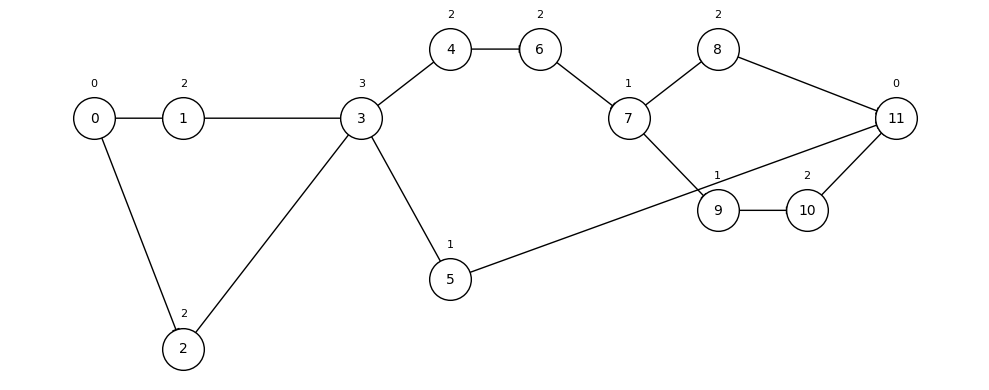

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

dg = nx.DiGraph()

Edge = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 3),
    (3, 4),
    (3, 5),
    (4, 6),
    (6, 7),
    (7, 8),
    (7, 9),
    (9, 10),
    (5, 11),
    (10, 11),
    (8, 11)
]
dg.add_edges_from(Edge)

# duration
d = {
    0: 0,
    1: 2,
    2: 2,
    3: 3,
    4: 2,
    5: 1,
    6: 2,
    7: 1,
    8: 2,
    9: 1,
    10: 2,
    11: 0,
}

pos = {
    0:  (0, 1),
    1:  (1, 1),
    2:  (1, 0),
    3:  (3, 1),
    4:  (4, 1.3),
    5:  (4, 0.3),
    6:  (5, 1.3),
    7:  (6, 1),
    8:  (7, 1.3),
    9:  (7, 0.6),
    10: (8, 0.6),
    11: (9, 1),
}


plt.figure(figsize=(10, 4))

nx.draw_networkx_edges(dg, pos, arrows=True, arrowstyle='-|>', arrowsize=12)
nx.draw_networkx_nodes(dg, pos, node_size=900, node_color='white', edgecolors='black')

nx.draw_networkx_labels(dg, pos, labels={n: n for n in dg.nodes()}, font_size=10)

for n, (x, y) in pos.items():
    dur = d.get(n, "")
    plt.text(x, y + 0.15, str(dur), ha='center', va='center', fontsize=8)

plt.axis('off')
plt.tight_layout()
plt.show()


In [27]:
from gurobipy import Model, GRB, quicksum

In [ ]:
# ============ 1. sample data  ============
N = 10                  # real modules 1..N
T = 35                 # time horizon

# installation duration
d = {1: 2, 2: 2, 3: 3,
     4: 2, 5: 1, 6: 2,
     7: 1, 8: 2, 9: 1,
     10: 2}

# precedence (i -> j)
E = [
    (1, 3),
    (2, 3),
    (3, 4),
    (3, 5),
    (4, 6),
    (6, 7),
    (7, 8),
    (7, 9),
    (9, 10)
]

# production duration (factory)
D = {1: 2, 2: 1, 3: 2,
     4: 1, 5: 1, 6: 2,
     7: 1, 8: 2, 9: 1,
     10:1}

    # transport / extra lead time
L = {1: 1, 2: 1, 3: 1,
        4: 1, 5: 1, 6: 1,
        7: 1, 8: 1, 9: 1,
        10:1}

# capacities
C_install = 2          # crews
M_machine = 4          # factory machines
S_site = 2             # site warehouse
S_fac = 2             # factory buffer (your new limit)

# costs
OC = 1.5               # order cost per batch
C_I = 2             # indirect cost per unit time
C_F = 0.8              # factory storage cost per unit

# dummies
dummy_start = 0
dummy_end = N + 1
d[dummy_start] = 0
d[dummy_end] = 0

# find roots & leaves
preds = {i: [] for i in range(1, N+1)}
succs = {i: [] for i in range(1, N+1)}
for (i, j) in E:
    succs[i].append(j)
    preds[j].append(i)
roots = [i for i in range(1, N+1) if len(preds[i]) == 0]
leaves = [i for i in range(1, N+1) if len(succs[i]) == 0]

# ============ 2. model ============
m = Model("prefab_with_factory_buffer")

# ============ 3. variables(correspond to my slide Decision Variables part)============
# x[i,t] start installation
x = {}
for i in range(0, N+2):     # include dummy 0 and dummy_end
    for t in range(1, T+1):
        x[i, t] = m.addVar(vtype=GRB.BINARY, name=f"x_{i}_{t}")

# y[i,t] installing (real activities only)
y = {}
for i in range(1, N+1):
    for t in range(1, T+1):
        y[i, t] = m.addVar(vtype=GRB.BINARY, name=f"y_{i}_{t}")

# p[i,t] arrival at site
p = {}
for i in range(1, N+1):
    for t in range(1, T+1):
        p[i, t] = m.addVar(vtype=GRB.BINARY, name=f"p_{i}_{t}")

# site storing
I = {}
for i in range(1, N+1):
    for t in range(1, T+1):
        I[i, t] = m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, name=f"I_{i}_{t}")

# factory production start
q = {}
for i in range(1, N+1):
    for t in range(1, T+1):
        q[i, t] = m.addVar(vtype=GRB.BINARY, name=f"q_{i}_{t}")

# order per time
z = {}
for t in range(1, T+1):
    z[t] = m.addVar(vtype=GRB.BINARY, name=f"z_{t}")

# factory storing
F = {}
for s in range(1, T+1):
    F[s] = m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, name=f"F_{s}")

m.update()

# ============ 4. constraints ============

# (1) dummy start fixed at time 1
m.addConstr(x[dummy_start, 1] == 1, "dummy_start_fix")
for t in range(2, T+1):
    m.addConstr(x[dummy_start, t] == 0, f"dummy_start_zero_{t}")

# (2) each real activity starts once
for i in range(1, N+1):
    m.addConstr(quicksum(x[i, t] for t in range(1, T+1)) == 1, f"start_once_{i}")

# (3) dummy end starts once
m.addConstr(quicksum(x[dummy_end, t] for t in range(1, T+1)) == 1, "dummy_end_once")

# (4) precedence between real activities
for (i, j) in E:
    start_i = quicksum(t * x[i, t] for t in range(1, T+1))
    start_j = quicksum(t * x[j, t] for t in range(1, T+1))
    m.addConstr(start_i + d[i] <= start_j, f"prec_{i}_{j}")

# (5) roots after dummy start (actually redundant since start>=1, but explicit, same as my slide)
for i in roots:
    start_i = quicksum(t * x[i, t] for t in range(1, T+1))
    m.addConstr(1 <= start_i, f"root_after_dummy_{i}")

# (6) leaves before dummy end
for i in leaves:
    start_i = quicksum(t * x[i, t] for t in range(1, T+1))
    end_d = quicksum(t * x[dummy_end, t] for t in range(1, T+1))
    m.addConstr(start_i + d[i] <= end_d, f"leaf_before_dummy_end_{i}")

# (7) installation state
for i in range(1, N+1):
    for t in range(1, T+1):
        tau_min = max(1, t - d[i] + 1)
        m.addConstr(
            y[i, t] == quicksum(x[i, tau] for tau in range(tau_min, t+1)),
            f"in_install_{i}_{t}"
        )

# (8) installation crew
for t in range(1, T+1):
    m.addConstr(quicksum(y[i, t] for i in range(1, N+1)) <= C_install, f"crew_{t}")

# (9) arrival once
for i in range(1, N+1):
    m.addConstr(quicksum(p[i, t] for t in range(1, T+1)) == 1, f"arrive_once_{i}")

# (10) arrival no later than installation
for i in range(1, N+1):
    arr = quicksum(t * p[i, t] for t in range(1, T+1))
    sta = quicksum(t * x[i, t] for t in range(1, T+1))
    m.addConstr(arr <= sta, f"arrive_before_install_{i}")

# (11) site storing balance
for i in range(1, N+1):
    # t = 1
    m.addConstr(I[i, 1] == p[i, 1] - x[i, 1], f"site_inv_init_{i}")
    # t >= 2
    for t in range(2, T+1):
        m.addConstr(
            I[i, t] == I[i, t-1] + p[i, t] - x[i, t],
            f"site_inv_bal_{i}_{t}"
        )

# (12) site warehouse capacity
for t in range(1, T+1):
    m.addConstr(
        quicksum(I[i, t] for i in range(1, N+1)) <= S_site,
        f"site_cap_{t}"
    )

# (13) production -> arrival timing
for i in range(1, N+1):
    for t in range(1, T+1):
        latest_prod = t - D[i] - L[i]
        if latest_prod >= 1:
            m.addConstr(
                p[i, t] <= quicksum(q[i, tau] for tau in range(1, latest_prod+1)),
                f"prod_to_arrive_{i}_{t}"
            )
        else:
            # cannot arrive this early
            m.addConstr(p[i, t] == 0, f"too_early_arrive_{i}_{t}")

# (14) factory machine capacity
for t in range(1, T+1):
    m.addConstr(
        quicksum(
            q[i, tau]
            for i in range(1, N+1)
            for tau in range(max(1, t - D[i] + 1), t+1)
        ) <= M_machine,
        f"machine_cap_{t}"
    )

# (15) order bundling
for t in range(1, T+1):
    for i in range(1, N+1):
        m.addConstr(p[i, t] <= z[t], f"link_order_{i}_{t}")

# (16) factory inventory: F1 = 0
m.addConstr(F[1] == 0, "factory_init")

# (17) factory inventory recursion
for s in range(2, T+1):
    finished_here = quicksum(
        q[i, s - D[i]] for i in range(1, N+1) if s - D[i] >= 1
    )
    shipped_here = quicksum(
        p[i, s + L[i]] for i in range(1, N+1) if s + L[i] <= T
    )
    m.addConstr(
        F[s] == F[s-1] + finished_here - shipped_here,
        f"factory_inv_bal_{s}"
    )

# (18) factory buffer capacity
for s in range(1, T+1):
    m.addConstr(F[s] <= S_fac, f"factory_cap_{s}")

# ============ 5. objective ============

# dummy end finish time
finish_time = quicksum(t * x[dummy_end, t] for t in range(1, T+1))

order_cost = quicksum(OC * z[t] for t in range(1, T+1))
factory_cost = quicksum(C_F * F[s] for s in range(1, T+1))
indirect_cost = C_I * finish_time

m.setObjective(order_cost + factory_cost + indirect_cost, GRB.MINIMIZE)

# ============ 6. solve ============
m.optimize()

# ============ 7. print solution (simple) ============
if m.Status == GRB.OPTIMAL or m.Status == GRB.TIME_LIMIT:
    print("Objective:", m.ObjVal)
    for i in range(1, N+1):
        for t in range(1, T+1):
            if x[i, t].X > 0.5:
                print(f"Module {i} installs at time {t}")
    for i in range(1, N+1):
        for t in range(1, T+1):
            if p[i, t].X > 0.5:
                print(f"Module {i} arrives at site at time {t}")
    for i in range(1, N+1):
        for t in range(1, T+1):
            if q[i, t].X > 0.5:
                print(f"Factory starts module {i} at time {t}")
    for s in range(1, T+1):
        if F[s].X > 1e-6:
            print(f"Factory inventory at time {s} = {F[s].X:.1f}")
    for t in range(1, T+1):
        if z[t].X > 0.5:
            print(f"Order at time {t}")
    #print the schedule of dummy end
    for t in range(1, T+1):
        if x[dummy_end, t].X > 0.5:
            print(f"Project finishes at time {t}")


Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-1340P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Academic license 2737007 - for non-commercial use only - registered to wa___@ethz.ch
Optimize a model with 1655 rows, 1890 columns and 13225 nonzeros (Min)
Model fingerprint: 0xcab69a51
Model has 105 linear objective coefficients
Variable types: 385 continuous, 1505 integer (1505 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [8e-01, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 625 rows and 732 columns
Presolve time: 0.03s
Presolved: 1030 rows, 1158 columns, 8554 nonzeros
Variable types: 0 continuous, 1158 integer (969 binary)
Found heuristic solution: objective 162.1000000
Found heuristic solution: objective 127.6000000

Root relaxation: objective 3.724643e+01, 1

In [1]:
import pandas as pd
import numpy as np

In [4]:
import random

In [2]:
stage_1_data = pd.read_excel(r'C:\2025AUTUMN\MT\25HS_MT_Joy\25HS_MT_Joy\Data\Timbeco\Rapla-design\411_Spetsifikatsioonid\NP2424_TP_EK-9-01_v01_Etapp-1-elementide-koond_v1.xlsx', skiprows = 5,
                             usecols = "B")
stage_1_data = stage_1_data.dropna(subset=[stage_1_data.columns[0]]).reset_index(drop=True)

In [3]:
print(stage_1_data)

       Pos NR
0    VS-02-31
1    VS-02-22
2    VS-02-21
3     VS-01-2
4     VS-01-8
5    VS-02-29
6    VS-02-92
7     VS-01-3
8    VS-01-21
9    VS-02-28
10   VS-02-93
11  VS-02-106
12   VS-02-58
13  VS-02-105
14   PS-01-11
15    PS-01-7
16    PS-01-4
17    PS-01-8
18   PS-01-12
19   KSS-02-1
20   KSS-02-2
21  KSS-01-26
22   KSS-01-5
23  KSS-01-11
24   KSS-01-4


In [6]:
random.seed(42)
np.random.seed(42)
module_ids = stage_1_data[stage_1_data.columns[0]].tolist()

In [15]:
df = pd.DataFrame(columns = ['Module_ID', 'Installation Duration', 'Production Duration', 'Transportation Duration', 'Installation Precedence'])
df['Module_ID'] = module_ids
df['Installation Duration'] = np.random.randint(1, 6, size=len(module_ids))
df['Production Duration'] = np.random.randint(1, 5, size=len(module_ids))
df['Transportation Duration'] = 2

max_lag = 3        
precedence = []

for i in range(len(module_ids)):
    if i < 3:
        precedence.append(None)
    else:
        start_idx = max(0, i - max_lag)
        possible_preds = module_ids[start_idx:i]
        pred = random.choice(possible_preds)
        precedence.append(pred)

df['Installation Precedence'] = precedence

In [17]:
df

,Module_ID,Installation Duration,Production Duration,Transportation Duration,Installation Precedence
0,VS-02-31,5,2,2,None
1,VS-02-22,2,1,2,None
2,VS-02-21,3,1,2,None
3,VS-01-2,1,2,2,VS-02-21
4,VS-01-8,2,4,2,VS-02-22
5,VS-02-29,2,4,2,VS-01-2
6,VS-02-92,4,4,2,VS-01-2
7,VS-01-3,5,4,2,VS-01-8
8,VS-01-21,3,4,2,VS-02-29
9,VS-02-28,1,2,2,VS-01-3


In [18]:
# visual in networkx
import networkx as nx
import matplotlib.pyplot as plt

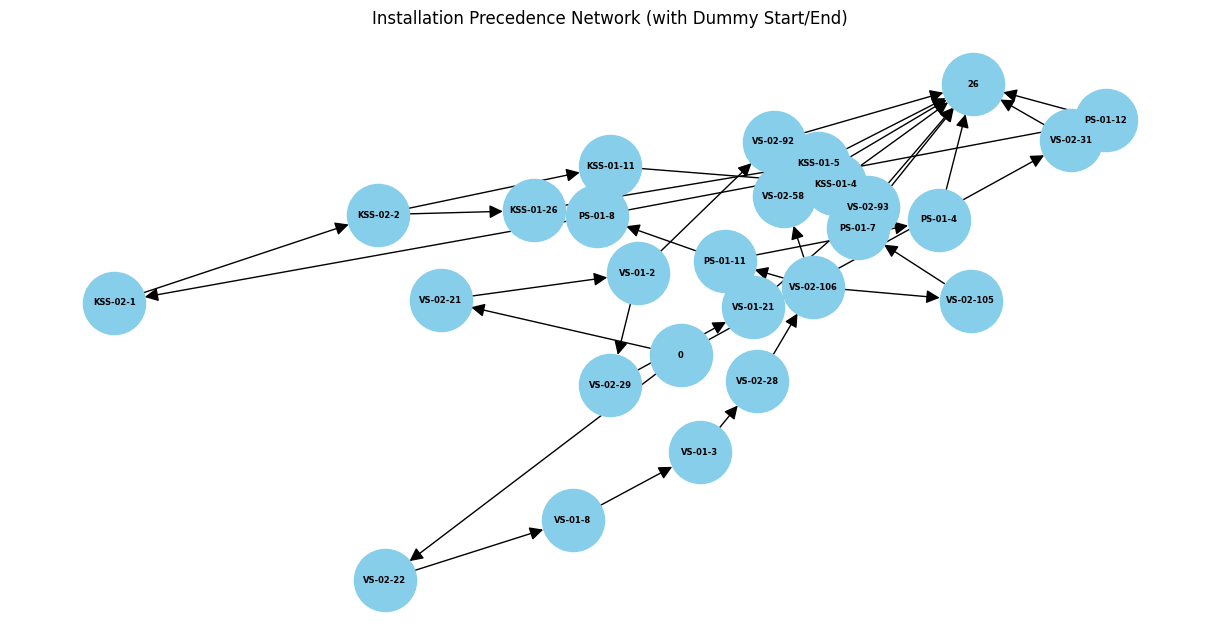

In [21]:
N = len(df)                     # 模块数量
dummy_start = 0
dummy_end   = N + 1

# 1. duration 字典（含 dummy 点，工期设为 0）
duration = dict(zip(df['Module_ID'], df['Installation Duration']))
duration[dummy_start] = 0
duration[dummy_end] = 0

# 2. precedence 字典（含 dummy 点）
precedence = {}

# 先对真实模块
for _, row in df.iterrows():
    j = row['Module_ID']
    pred = row['Installation Precedence']
    if pd.isna(pred) or pred is None:
        precedence.setdefault(j, [])
    else:
        precedence.setdefault(j, []).append(pred)

# 3. 构建有向图并加入 dummy start / end
dxg = nx.DiGraph()

# 实际 precedence 边
for j, preds in precedence.items():
    for p in preds:
        dxg.add_edge(p, j)

# 从 dummy_start → 所有“没有前置”的模块
no_pred_modules = [m for m, preds in precedence.items() if len(preds) == 0]
for m in no_pred_modules:
    dxg.add_edge(dummy_start, m)

# 从所有“没有后继”的模块 → dummy_end
all_nodes = set(df['Module_ID'])
succ_set = {u for (u, v) in dxg.edges() if u in all_nodes}
# 先默认所有真实节点都可能是末尾
no_succ_modules = all_nodes - {u for (u, v) in dxg.edges() if u in all_nodes}
for m in no_succ_modules:
    dxg.add_edge(m, dummy_end)

# 4. 画图
plt.figure(figsize=(12, 6))
pos = nx.spring_layout(dxg, seed=42)

nx.draw(
    dxg, pos,
    with_labels=True,
    node_size=2000,
    node_color="skyblue",
    font_size=6,
    font_weight="bold",
    arrowsize=20,
)

plt.title("Installation Precedence Network (with Dummy Start/End)")
plt.show()


In [23]:
from collections import defaultdict

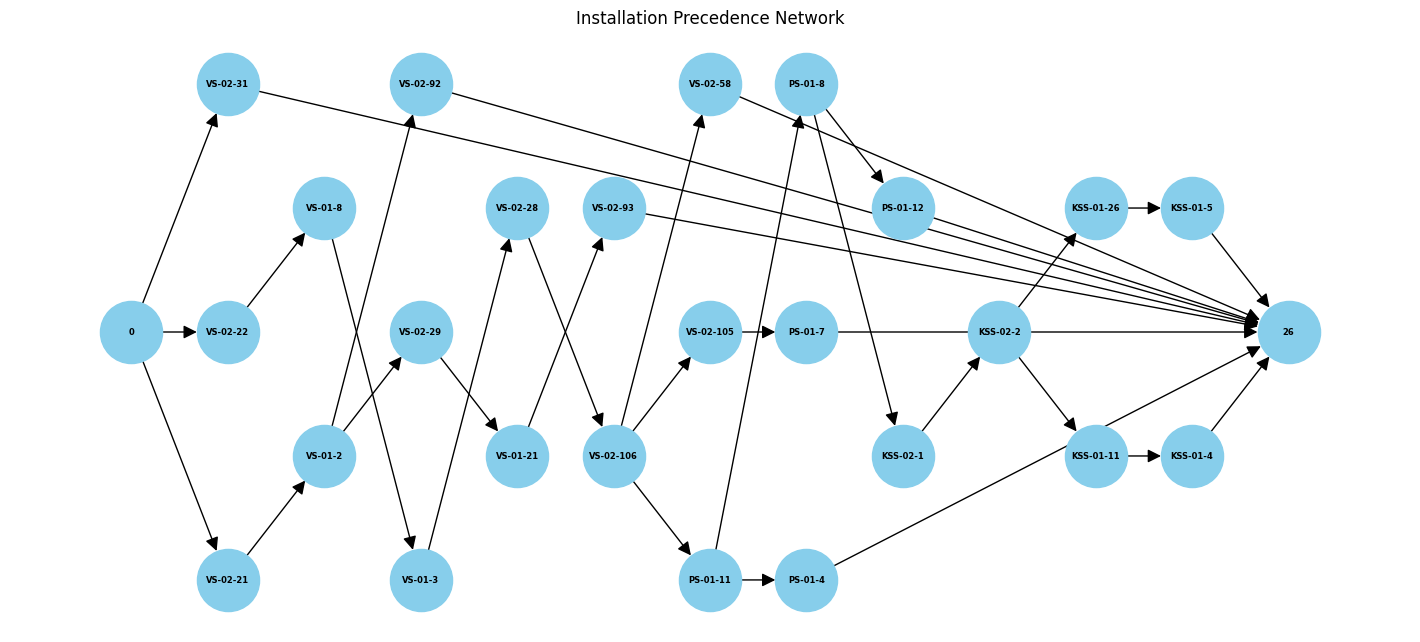

In [25]:
levels = {}
topo_order = list(nx.topological_sort(dxg))

for node in topo_order:
    preds = list(dxg.predecessors(node))
    if not preds:          # 没有前驱（比如 dummy start）
        levels[node] = 0
    else:
        levels[node] = max(levels[p] + 1 for p in preds)

# 2. 按层分组
level_nodes = defaultdict(list)
for node, lvl in levels.items():
    level_nodes[lvl].append(node)

# 3. 为每一层的节点生成整齐坐标
pos = {}
x_gap = 2.0   # 每层之间的间距
y_gap = 1.5   # 同层节点之间的间距

for lvl, nodes in sorted(level_nodes.items()):
    # 让同一层节点上下居中排布
    n = len(nodes)
    y_start = -(n - 1) * y_gap / 2.0
    for i, node in enumerate(sorted(nodes, key=str)):  # 排个序，看起来更整齐
        x = lvl * x_gap
        y = y_start + i * y_gap
        pos[node] = (x, y)

# 4. 画图
plt.figure(figsize=(14, 6))
nx.draw(
    dxg, pos,
    with_labels=True,
    node_size=2000,
    node_color="skyblue",
    font_size=6,
    font_weight="bold",
    arrowsize=20,
)
plt.title("Installation Precedence Network")
plt.axis('off')
plt.show()

In [34]:
from gurobipy import Model, GRB, quicksum

class PrefabScheduler:
    def __init__(self,
                 N,
                 T,
                 d,
                 E,
                 D,
                 L,
                 C_install,
                 M_machine,
                 S_site,
                 S_fac,
                 OC,
                 C_I,
                 C_F):
        """
        in English
        N: number of modules (real modules 1..N)
        T: time horizon
        d: installation duration dict{i: duration}
        E: installation precedence list of (i, j)
        D: factory production duration dict{i: duration}
        L: transport / extra lead time dict{i: lead time}
        C_install: crew number at site
        M_machine: machine number at factory
        S_site: onsite storage capacity
        S_fac: factory buffer storage capacity
        OC: cost per order batch
        C_I: penalty cost per unit time
        C_F: factory inventory cost per unit time per unit
        """
        self.N = N
        self.T = T
        self.d = d.copy()
        self.E = E
        self.D = D
        self.L = L
        self.C_install = C_install
        self.M_machine = M_machine
        self.S_site = S_site
        self.S_fac = S_fac
        self.OC = OC
        self.C_I = C_I
        self.C_F = C_F

        # dummies
        self.dummy_start = 0
        self.dummy_end = N + 1
        self.d[self.dummy_start] = 0
        self.d[self.dummy_end] = 0

        # placeholders: model & variables
        self.m = None
        self.x = {}
        self.y = {}
        self.p = {}
        self.I = {}
        self.q = {}
        self.z = {}
        self.F = {}

        # preprocessing roots / leaves
        self.roots, self.leaves = self._find_roots_and_leaves()

    def _find_roots_and_leaves(self):
        preds = {i: [] for i in range(1, self.N + 1)}
        succs = {i: [] for i in range(1, self.N + 1)}
        for (i, j) in self.E:
            succs[i].append(j)
            preds[j].append(i)
        roots = [i for i in range(1, self.N + 1) if len(preds[i]) == 0]
        leaves = [i for i in range(1, self.N + 1) if len(succs[i]) == 0]    
        return roots, leaves

    def build_model(self):
        m = Model("prefab_with_factory_buffer")
        m.Params.TimeLimit = 120      # 最多算 600 秒
        m.Params.MIPGap    = 0.02     # 允许 2% 最优间隙
        m.Params.MIPFocus  = 1        # 更关注找可行解
        m.Params.Heuristics = 0.2     # 增强启发式（默认 0.05 左右）
        m.Params.Cuts = 0             # 如果节点过多，可以适当减弱 cuts
        # 利用多核（如果有的话）
        m.Params.Threads = 0   

        N, T = self.N, self.T
        d = self.d
        D = self.D
        L = self.L
        dummy_start = self.dummy_start
        dummy_end = self.dummy_end

        # ============ 3. variables ============
        # x[i,t] start installation (including dummy)
        x = {}
        for i in range(0, N + 2):
            for t in range(1, T + 1):
                x[i, t] = m.addVar(vtype=GRB.BINARY, name=f"x_{i}_{t}")

        # y[i,t] installing (only real activities)
        y = {}
        for i in range(1, N + 1):
            for t in range(1, T + 1):
                y[i, t] = m.addVar(vtype=GRB.BINARY, name=f"y_{i}_{t}")

        # p[i,t] arrival at site
        p = {}
        for i in range(1, N + 1):
            for t in range(1, T + 1):
                p[i, t] = m.addVar(vtype=GRB.BINARY, name=f"p_{i}_{t}")

        # site inventory
        I = {}
        for i in range(1, N + 1):
            for t in range(1, T + 1):
                I[i, t] = m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, name=f"I_{i}_{t}")

        # factory production start
        q = {}
        for i in range(1, N + 1):
            for t in range(1, T + 1):
                q[i, t] = m.addVar(vtype=GRB.BINARY, name=f"q_{i}_{t}")

        # order per time (batch)
        z = {}
        for t in range(1, T + 1):
            z[t] = m.addVar(vtype=GRB.BINARY, name=f"z_{t}")

        # factory inventory
        F = {}
        for s in range(1, T + 1):
            F[s] = m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, name=f"F_{s}")

        m.update()

        # ============ 4. constraints ============

        # (1) dummy start fixed at time 1
        m.addConstr(x[dummy_start, 1] == 1, "dummy_start_fix")
        for t in range(2, T + 1):
            m.addConstr(x[dummy_start, t] == 0, f"dummy_start_zero_{t}")

        # (2) each real activity starts once
        for i in range(1, N + 1):
            m.addConstr(quicksum(x[i, t] for t in range(1, T + 1)) == 1,
                        f"start_once_{i}")

        # (3) dummy end starts once
        m.addConstr(quicksum(x[dummy_end, t] for t in range(1, T + 1)) == 1,
                    "dummy_end_once")

        # (4) precedence between real activities
        for (i, j) in self.E:
            start_i = quicksum(t * x[i, t] for t in range(1, T + 1))
            start_j = quicksum(t * x[j, t] for t in range(1, T + 1))
            m.addConstr(start_i + d[i] <= start_j, f"prec_{i}_{j}")

        # (5) roots after dummy start
        for i in self.roots:
            start_i = quicksum(t * x[i, t] for t in range(1, T + 1))
            m.addConstr(1 <= start_i, f"root_after_dummy_{i}")

        # (6) leaves before dummy end
        for i in self.leaves:
            start_i = quicksum(t * x[i, t] for t in range(1, T + 1))
            end_d = quicksum(t * x[dummy_end, t] for t in range(1, T + 1))
            m.addConstr(start_i + d[i] <= end_d, f"leaf_before_dummy_end_{i}")

        # (7) installation state
        for i in range(1, N + 1):
            for t in range(1, T + 1):
                tau_min = max(1, t - d[i] + 1)
                m.addConstr(
                    y[i, t] == quicksum(x[i, tau] for tau in range(tau_min, t + 1)),
                    f"in_install_{i}_{t}"
                )

        # (8) installation crew capacity
        for t in range(1, T + 1):
            m.addConstr(quicksum(y[i, t] for i in range(1, N + 1)) <= self.C_install,
                        f"crew_{t}")

        # (9) arrival once
        for i in range(1, N + 1):
            m.addConstr(quicksum(p[i, t] for t in range(1, T + 1)) == 1,
                        f"arrive_once_{i}")

        # (10) arrival no later than installation start
        for i in range(1, N + 1):
            arr = quicksum(t * p[i, t] for t in range(1, T + 1))
            sta = quicksum(t * x[i, t] for t in range(1, T + 1))
            m.addConstr(arr <= sta, f"arrive_before_install_{i}")

        # (11) site inventory balance
        for i in range(1, N + 1):
            # t = 1
            m.addConstr(I[i, 1] == p[i, 1] - x[i, 1], f"site_inv_init_{i}")
            # t >= 2
            for t in range(2, T + 1):
                m.addConstr(
                    I[i, t] == I[i, t - 1] + p[i, t] - x[i, t],
                    f"site_inv_bal_{i}_{t}"
                )

        # (12) site warehouse capacity
        for t in range(1, T + 1):
            m.addConstr(
                quicksum(I[i, t] for i in range(1, N + 1)) <= self.S_site,
                f"site_cap_{t}"
            )

        # (13) production -> arrival timing
        for i in range(1, N + 1):
            for t in range(1, T + 1):
                latest_prod = t - D[i] - L[i]
                if latest_prod >= 1:
                    m.addConstr(
                        p[i, t] <= quicksum(q[i, tau] for tau in range(1, latest_prod + 1)),
                        f"prod_to_arrive_{i}_{t}"
                    )
                else:
                    # cannot arrive this early
                    m.addConstr(p[i, t] == 0, f"too_early_arrive_{i}_{t}")

        # (14) factory machine capacity
        for t in range(1, T + 1):
            m.addConstr(
                quicksum(
                    q[i, tau]
                    for i in range(1, N + 1)
                    for tau in range(max(1, t - D[i] + 1), t + 1)
                ) <= self.M_machine,
                f"machine_cap_{t}"
            )

        # (15) order bundling
        for t in range(1, T + 1):
            for i in range(1, N + 1):
                m.addConstr(p[i, t] <= z[t], f"link_order_{i}_{t}")

        # (16) factory inventory: F1 = 0
        m.addConstr(F[1] == 0, "factory_init")

        # (17) factory inventory recursion
        for s in range(2, T + 1):
            finished_here = quicksum(
                q[i, s - D[i]] for i in range(1, N + 1) if s - D[i] >= 1
            )
            shipped_here = quicksum(
                p[i, s + L[i]] for i in range(1, N + 1) if s + L[i] <= T
            )
            m.addConstr(
                F[s] == F[s - 1] + finished_here - shipped_here,
                f"factory_inv_bal_{s}"
            )

        # (18) factory buffer capacity
        for s in range(1, T + 1):
            m.addConstr(F[s] <= self.S_fac, f"factory_cap_{s}")

        # ============ 5. objective ============
        finish_time = quicksum(t * x[dummy_end, t] for t in range(1, T + 1))
        order_cost = quicksum(self.OC * z[t] for t in range(1, T + 1))
        factory_cost = quicksum(self.C_F * F[s] for s in range(1, T + 1))
        indirect_cost = self.C_I * finish_time

        m.setObjective(order_cost + factory_cost + indirect_cost, GRB.MINIMIZE)

        # 保存对象
        self.m = m
        self.x = x
        self.y = y
        self.p = p
        self.I = I
        self.q = q
        self.z = z
        self.F = F

        return m

    def solve(self, time_limit=None, mip_gap=None):
        if self.m is None:
            self.build_model()

        if time_limit is not None:
            self.m.Params.TimeLimit = time_limit
        if mip_gap is not None:
            self.m.Params.MIPGap = mip_gap

        self.m.optimize()
        return self.m.Status

    def print_solution(self):
        m = self.m
        if m is None:
            print("Model not built.")
            return

        if m.Status not in [GRB.OPTIMAL, GRB.TIME_LIMIT]:
            print(f"Model status: {m.Status}")
            return

        print("Objective:", m.ObjVal)
        N, T = self.N, self.T
        x, p, q, F, z = self.x, self.p, self.q, self.F, self.z
        dummy_end = self.dummy_end

        for i in range(1, N + 1):
            for t in range(1, T + 1):
                if x[i, t].X > 0.5:
                    print(f"Module {i} installs at time {t}")

        for i in range(1, N + 1):
            for t in range(1, T + 1):
                if p[i, t].X > 0.5:
                    print(f"Module {i} arrives at site at time {t}")

        for i in range(1, N + 1):
            for t in range(1, T + 1):
                if q[i, t].X > 0.5:
                    print(f"Factory starts module {i} at time {t}")

        for s in range(1, T + 1):
            if F[s].X > 1e-6:
                print(f"Factory inventory at time {s} = {F[s].X:.1f}")

        for t in range(1, T + 1):
            if z[t].X > 0.5:
                print(f"Order at time {t}")

        for t in range(1, T + 1):
            if x[dummy_end, t].X > 0.5:
                print(f"Project finishes at time {t}")
                break


In [35]:
# ====== 1. Define data ======
N = 25
T = 80

d = {}
D = {}
L = {}

for index, row in df.iterrows():
    idx = index + 1   # 模块编号从 1 开始
    d[idx] = int(row['Installation Duration'])
    D[idx] = int(row['Production Duration'])
    L[idx] = int(row['Transportation Duration'])

id_to_idx = {}   # 'VS-02-31' -> 1, 'VS-02-22' -> 2, ...

for idx, row in df.iterrows():
    id_to_idx[row['Module_ID']] = idx + 1  

E = []
for _, row in df.iterrows():
    j_id = row['Module_ID']
    pred_id = row['Installation Precedence']
    if pd.isna(pred_id) or pred_id is None:
        continue
    i = id_to_idx[pred_id]
    j = id_to_idx[j_id]
    E.append((i, j))


C_install = 2
M_machine = 4
S_site = 5
S_fac = 8

OC = 1.5
C_I = 2.0
C_F = 0.8

scheduler = PrefabScheduler(
    N=N,
    T=T,
    d=d,
    E=E,
    D=D,
    L=L,
    C_install=C_install,
    M_machine=M_machine,
    S_site=S_site,
    S_fac=S_fac,
    OC=OC,
    C_I=C_I,
    C_F=C_F
)

scheduler.build_model()
scheduler.solve()
scheduler.print_solution()


Set parameter TimeLimit to value 120
Set parameter MIPGap to value 0.02
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.2
Set parameter Cuts to value 0
Set parameter Threads to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-1340P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  120
MIPGap  0.02
Heuristics  0.2
MIPFocus  1
Cuts  0

Academic license 2737007 - for non-commercial use only - registered to wa___@ethz.ch
Optimize a model with 8590 rows, 10320 columns and 121415 nonzeros (Min)
Model fingerprint: 0x4d964a9d
Model has 240 linear objective coefficients
Variable types: 2080 continuous, 8240 integer (8240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e-01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Presolve 

In [36]:
from pyscipopt import Model, quicksum

class PrefabSchedulerSCIP:
    def __init__(self,
                 N,
                 T,
                 d,
                 E,
                 D,
                 L,
                 C_install,
                 M_machine,
                 S_site,
                 S_fac,
                 OC,
                 C_I,
                 C_F):
        """
        N: 模块数（真实模块 1..N）
        T: 时间跨度
        d: 安装工期 dict{i: duration}
        E: 安装工序前后关系 list of (i, j)
        D: 工厂生产工期 dict{i: duration}
        L: 运输/额外提前期 dict{i: lead time}
        C_install: 现场安装班组容量
        M_machine: 工厂机器容量
        S_site: 现场仓储容量
        S_fac: 工厂缓冲仓储容量
        OC: 每次订单固定成本
        C_I: 间接成本系数（乘工程完工时间）
        C_F: 工厂库存单位时间成本
        """
        self.N = N
        self.T = T
        self.d = d.copy()
        self.E = E
        self.D = D
        self.L = L
        self.C_install = C_install
        self.M_machine = M_machine
        self.S_site = S_site
        self.S_fac = S_fac
        self.OC = OC
        self.C_I = C_I
        self.C_F = C_F

        # dummies
        self.dummy_start = 0
        self.dummy_end = N + 1
        self.d[self.dummy_start] = 0
        self.d[self.dummy_end] = 0

        # 占位：model & variables
        self.m = None
        self.x = {}
        self.y = {}
        self.p = {}
        self.I = {}
        self.q = {}
        self.z = {}
        self.F = {}

        # 预处理 roots / leaves
        self.roots, self.leaves = self._find_roots_and_leaves()

    def _find_roots_and_leaves(self):
        preds = {i: [] for i in range(1, self.N + 1)}
        succs = {i: [] for i in range(1, self.N + 1)}
        for (i, j) in self.E:
            succs[i].append(j)
            preds[j].append(i)
        roots = [i for i in range(1, self.N + 1) if len(preds[i]) == 0]
        leaves = [i for i in range(1, self.N + 1) if len(succs[i]) == 0]
        return roots, leaves

    def build_model(self):
        m = Model("prefab_with_factory_buffer_scip")

        N, T = self.N, self.T
        d = self.d
        D = self.D
        L = self.L
        dummy_start = self.dummy_start
        dummy_end = self.dummy_end

        # ============ 3. variables ============
        # x[i,t] start installation (含 dummy)
        x = {}
        for i in range(0, N + 2):
            for t in range(1, T + 1):
                x[i, t] = m.addVar(vtype="B", name=f"x_{i}_{t}")

        # y[i,t] installing (only real activities)
        y = {}
        for i in range(1, N + 1):
            for t in range(1, T + 1):
                y[i, t] = m.addVar(vtype="B", name=f"y_{i}_{t}")

        # p[i,t] arrival at site
        p = {}
        for i in range(1, N + 1):
            for t in range(1, T + 1):
                p[i, t] = m.addVar(vtype="B", name=f"p_{i}_{t}")

        # site inventory
        I = {}
        for i in range(1, N + 1):
            for t in range(1, T + 1):
                I[i, t] = m.addVar(vtype="C", lb=0.0, name=f"I_{i}_{t}")

        # factory production start
        q = {}
        for i in range(1, N + 1):
            for t in range(1, T + 1):
                q[i, t] = m.addVar(vtype="B", name=f"q_{i}_{t}")

        # order per time (batch)
        z = {}
        for t in range(1, T + 1):
            z[t] = m.addVar(vtype="B", name=f"z_{t}")

        # factory inventory
        F = {}
        for s in range(1, T + 1):
            F[s] = m.addVar(vtype="C", lb=0.0, name=f"F_{s}")

        # ============ 4. constraints ============

        # (1) dummy start fixed at time 1
        m.addCons(x[dummy_start, 1] == 1, name="dummy_start_fix")
        for t in range(2, T + 1):
            m.addCons(x[dummy_start, t] == 0, name=f"dummy_start_zero_{t}")

        # (2) each real activity starts once
        for i in range(1, N + 1):
            m.addCons(quicksum(x[i, t] for t in range(1, T + 1)) == 1,
                      name=f"start_once_{i}")

        # (3) dummy end starts once
        m.addCons(quicksum(x[dummy_end, t] for t in range(1, T + 1)) == 1,
                  name="dummy_end_once")

        # (4) precedence between real activities
        for (i, j) in self.E:
            start_i = quicksum(t * x[i, t] for t in range(1, T + 1))
            start_j = quicksum(t * x[j, t] for t in range(1, T + 1))
            m.addCons(start_i + d[i] <= start_j, name=f"prec_{i}_{j}")

        # (5) roots after dummy start
        for i in self.roots:
            start_i = quicksum(t * x[i, t] for t in range(1, T + 1))
            m.addCons(1 <= start_i, name=f"root_after_dummy_{i}")

        # (6) leaves before dummy end
        for i in self.leaves:
            start_i = quicksum(t * x[i, t] for t in range(1, T + 1))
            end_d = quicksum(t * x[dummy_end, t] for t in range(1, T + 1))
            m.addCons(start_i + d[i] <= end_d, name=f"leaf_before_dummy_end_{i}")

        # (7) installation state
        for i in range(1, N + 1):
            for t in range(1, T + 1):
                tau_min = max(1, t - d[i] + 1)
                m.addCons(
                    y[i, t] == quicksum(x[i, tau] for tau in range(tau_min, t + 1)),
                    name=f"in_install_{i}_{t}"
                )

        # (8) installation crew capacity
        for t in range(1, T + 1):
            m.addCons(quicksum(y[i, t] for i in range(1, N + 1)) <= self.C_install,
                      name=f"crew_{t}")

        # (9) arrival once
        for i in range(1, N + 1):
            m.addCons(quicksum(p[i, t] for t in range(1, T + 1)) == 1,
                      name=f"arrive_once_{i}")

        # (10) arrival no later than installation start
        for i in range(1, N + 1):
            arr = quicksum(t * p[i, t] for t in range(1, T + 1))
            sta = quicksum(t * x[i, t] for t in range(1, T + 1))
            m.addCons(arr <= sta, name=f"arrive_before_install_{i}")

        # (11) site inventory balance
        for i in range(1, N + 1):
            # t = 1
            m.addCons(I[i, 1] == p[i, 1] - x[i, 1], name=f"site_inv_init_{i}")
            # t >= 2
            for t in range(2, T + 1):
                m.addCons(
                    I[i, t] == I[i, t - 1] + p[i, t] - x[i, t],
                    name=f"site_inv_bal_{i}_{t}"
                )

        # (12) site warehouse capacity
        for t in range(1, T + 1):
            m.addCons(
                quicksum(I[i, t] for i in range(1, N + 1)) <= self.S_site,
                name=f"site_cap_{t}"
            )

        # (13) production -> arrival timing
        for i in range(1, N + 1):
            for t in range(1, T + 1):
                latest_prod = t - D[i] - L[i]
                if latest_prod >= 1:
                    m.addCons(
                        p[i, t] <= quicksum(q[i, tau] for tau in range(1, latest_prod + 1)),
                        name=f"prod_to_arrive_{i}_{t}"
                    )
                else:
                    # cannot arrive this early
                    m.addCons(p[i, t] == 0, name=f"too_early_arrive_{i}_{t}")

        # (14) factory machine capacity
        for t in range(1, T + 1):
            m.addCons(
                quicksum(
                    q[i, tau]
                    for i in range(1, N + 1)
                    for tau in range(max(1, t - D[i] + 1), t + 1)
                ) <= self.M_machine,
                name=f"machine_cap_{t}"
            )

        # (15) order bundling
        for t in range(1, T + 1):
            for i in range(1, N + 1):
                m.addCons(p[i, t] <= z[t], name=f"link_order_{i}_{t}")

        # (16) factory inventory: F1 = 0
        m.addCons(F[1] == 0, name="factory_init")

        # (17) factory inventory recursion
        for s in range(2, T + 1):
            finished_here = quicksum(
                q[i, s - D[i]] for i in range(1, N + 1) if s - D[i] >= 1
            )
            shipped_here = quicksum(
                p[i, s + L[i]] for i in range(1, N + 1) if s + L[i] <= T
            )
            m.addCons(
                F[s] == F[s - 1] + finished_here - shipped_here,
                name=f"factory_inv_bal_{s}"
            )

        # (18) factory buffer capacity
        for s in range(1, T + 1):
            m.addCons(F[s] <= self.S_fac, name=f"factory_cap_{s}")

        # ============ 5. objective ============
        finish_time = quicksum(t * x[dummy_end, t] for t in range(1, T + 1))
        order_cost = quicksum(self.OC * z[t] for t in range(1, T + 1))
        factory_cost = quicksum(self.C_F * F[s] for s in range(1, T + 1))
        indirect_cost = self.C_I * finish_time

        obj = order_cost + factory_cost + indirect_cost
        m.setObjective(obj, sense="minimize")

        # 保存对象
        self.m = m
        self.x = x
        self.y = y
        self.p = p
        self.I = I
        self.q = q
        self.z = z
        self.F = F

        return m

    def solve(self, time_limit=None, gap=None):
        if self.m is None:
            self.build_model()

        # 设置时间 & gap（可选）
        if time_limit is not None:
            self.m.setRealParam("limits/time", float(time_limit))
        if gap is not None:
            # 相对 gap
            self.m.setRealParam("limits/gap", float(gap))

        self.m.optimize()
        return self.m.getStatus()

    def print_solution(self):
        m = self.m
        if m is None:
            print("Model not built.")
            return

        status = m.getStatus()
        if status not in ["optimal", "timelimit"]:
            print(f"Model status: {status}")
            return

        print("Status:", status)
        print("Objective:", m.getObjVal())

        N, T = self.N, self.T
        x, p, q, F, z = self.x, self.p, self.q, self.F, self.z
        dummy_end = self.dummy_end

        # 安装时间
        for i in range(1, N + 1):
            for t in range(1, T + 1):
                if m.getVal(x[i, t]) > 0.5:
                    print(f"Module {i} installs at time {t}")

        # 到场时间
        for i in range(1, N + 1):
            for t in range(1, T + 1):
                if m.getVal(p[i, t]) > 0.5:
                    print(f"Module {i} arrives at site at time {t}")

        # 工厂生产开始
        for i in range(1, N + 1):
            for t in range(1, T + 1):
                if m.getVal(q[i, t]) > 0.5:
                    print(f"Factory starts module {i} at time {t}")

        # 工厂库存
        for s in range(1, T + 1):
            val = m.getVal(F[s])
            if val > 1e-6:
                print(f"Factory inventory at time {s} = {val:.1f}")

        # 订单时间
        for t in range(1, T + 1):
            if m.getVal(z[t]) > 0.5:
                print(f"Order at time {t}")

        # 完工时间
        for t in range(1, T + 1):
            if m.getVal(x[dummy_end, t]) > 0.5:
                print(f"Project finishes at time {t}")
                break


In [37]:

# ====== 调用 SCIP 版本 ======
scheduler_scip = PrefabSchedulerSCIP(
    N=N,
    T=T,
    d=d,
    E=E,
    D=D,
    L=L,
    C_install=C_install,
    M_machine=M_machine,
    S_site=S_site,
    S_fac=S_fac,
    OC=OC,
    C_I=C_I,
    C_F=C_F
)

scheduler_scip.build_model()
status = scheduler_scip.solve(time_limit=120, gap=0.02)
scheduler_scip.print_solution()


Status: timelimit
Objective: -22.400000000000002
Module 7 arrives at site at time 79
Module 11 arrives at site at time 79
Module 13 arrives at site at time 79
Module 16 arrives at site at time 79
Module 17 arrives at site at time 79
Module 19 arrives at site at time 79
Module 23 arrives at site at time 79
